### IMPORTS

In [11]:
from datasets import load_dataset

dataset = load_dataset("data-is-better-together/fineweb-c", name="dan_Latn")

### SAMPLES

In [22]:
import random
from datasets import load_dataset

dataset = load_dataset("data-is-better-together/fineweb-c", name="dan_Latn")
all_data = dataset["train"]

print("Example keys:", all_data[0].keys())

random.seed(1337)
sampled_indices = random.sample(range(len(all_data)), 50)
sampled_data = [(i, all_data[i]) for i in sampled_indices]


for idx, sample in sampled_data:
    print(f"--- Sample ID: {idx} ---")
    print("Text:")
    print(sample['text'])
    print("\nOriginal Labels from Annotators:")
    
    for key in sample.keys():
        if "annotator" in key.lower() or "label" in key.lower() or "quality" in key.lower():
            print(f"{key}: {sample[key]}")
    
    print("\n" + "-" * 60 + "\n")


Example keys: dict_keys(['id', 'text', 'educational_value_labels', 'annotator_ids', 'problematic_content_label_present', 'problematic_content_label_agreement', 'language_names', 'language_code'])
--- Sample ID: 632 ---
Text:
Målgruppe: AMU-kurset er et introduktionskursus til mekanisk måleteknik i metalindustriel produktion, og henvender sig til ufaglærte og faglærte operatører, som har - eller søger - arbejde i den spåntagende metalindustri.AMU-kurset kan f.eks. anvendes forud for deltagelse på AMU kurser inden for måleteknik, tegningsforståelse, CAD/CAM samt spåntagende bearbejdning.
Beskrivelse: Deltageren kan efter kurset selvstændigt aflæse emnetegninger og/eller kontrolspecifikationer og ud fra disse udføre kontrolmålinger med anvist fast og stilbart kontrolværktøj. Deltageren kan med viden om temperaturens indflydelse på måleresultatet selvstændigt foretage opmåling af emner herunder anvende og aflæse følgende måleinstrumenter korrekt: skydelære, gradmåler samt fast kontrolværkt

In [ ]:
import csv

with open("samples_for_annotation.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "text", "original_labels", "your_annotation"])
    
    for idx, sample in sampled_data:
        text = sample["text"]
        labels = sample.get("quality", "N/A")
        writer.writerow([idx, text, labels, ""])


### RELABELING

In [15]:
from collections import Counter

priority_order = ["Excellent", "Good", "Basic", "Minimal", "None", "❗ Problematic Content ❗"]

single_labels = []


for labels in dataset['train']['educational_value_labels']:
    label_counts = Counter(labels)
    max_count = max(label_counts.values())
    

    candidates = [label for label, count in label_counts.items() if count == max_count]
    

    candidates.sort(key=lambda label: priority_order.index(label))
    
    single_labels.append(candidates[0])  


single_label_counts = Counter(single_labels)


for label in priority_order:
    print(f"{label}: {single_label_counts.get(label, 0)}")

print(f"\nTotal examples: {sum(single_label_counts.values())}")



Excellent: 5
Good: 25
Basic: 89
Minimal: 297
None: 463
❗ Problematic Content ❗: 121

Total examples: 1000


/var/folders/z5/n4953y3d781810x5g1_db6b00000gn/T/ipykernel_7776/2112608881.py:13: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


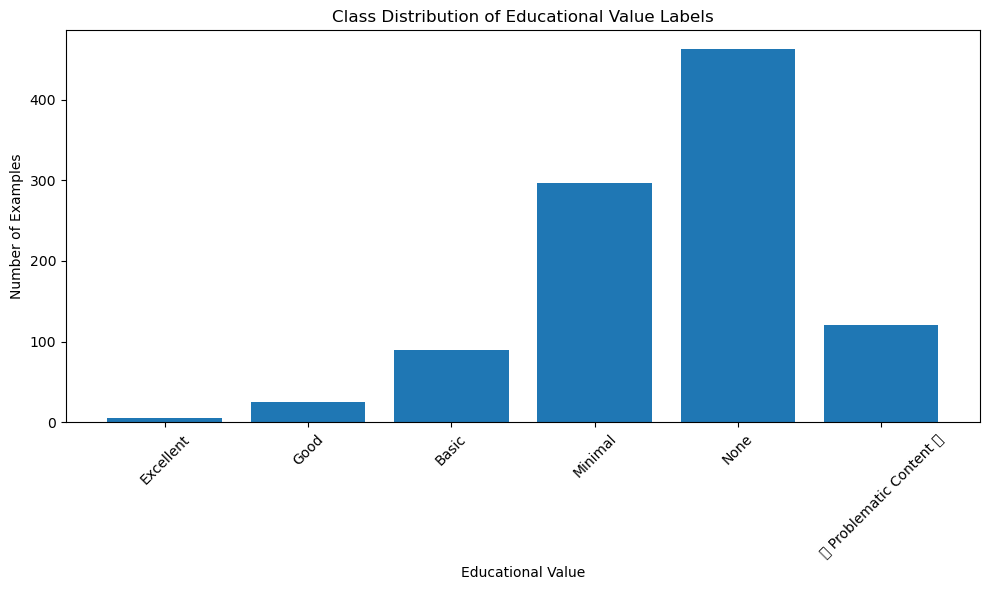

In [16]:
import matplotlib.pyplot as plt


labels = priority_order
counts = [single_label_counts.get(label, 0) for label in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel("Educational Value")
plt.ylabel("Number of Examples")
plt.title("Class Distribution of Educational Value Labels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### LIX

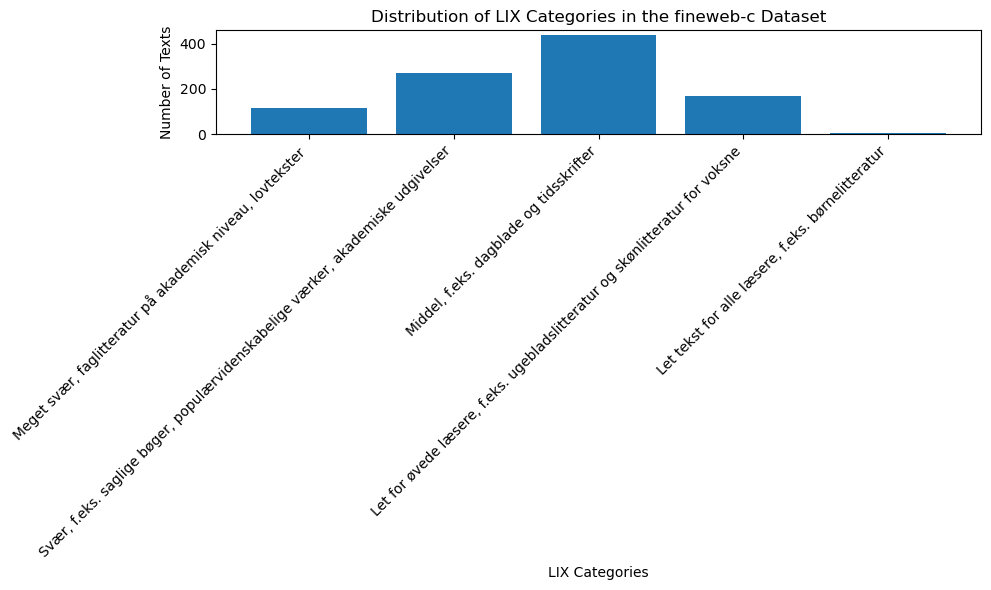

In [14]:
import re
from collections import Counter
import matplotlib.pyplot as plt
from datasets import load_dataset


dataset = load_dataset("data-is-better-together/fineweb-c", name="dan_Latn")

#function to compute the LIX score for a text
def compute_lix(text):
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    num_sentences = len(sentences) if sentences else 1


    words = re.findall(r'\w+', text)
    num_words = len(words)
    

    long_words = [word for word in words if len(word) > 6]
    num_long_words = len(long_words)
    
 
    lix = (num_words / num_sentences) + (num_long_words * 100 / num_words) if num_words > 0 else 0
    return lix


def lix_category(lix):
    if lix >= 55:
        return "Meget svær, faglitteratur på akademisk niveau, lovtekster"
    elif 45 <= lix < 55:
        return "Svær, f.eks. saglige bøger, populærvidenskabelige værker, akademiske udgivelser"
    elif 35 <= lix < 45:
        return "Middel, f.eks. dagblade og tidsskrifter"
    elif 25 <= lix < 35:
        return "Let for øvede læsere, f.eks. ugebladslitteratur og skønlitteratur for voksne"
    else:  # lix <= 24
        return "Let tekst for alle læsere, f.eks. børnelitteratur"


categories = []
for example in dataset['train']:
    text = example['text']  
    lix_score = compute_lix(text)
    category = lix_category(lix_score)
    categories.append(category)


category_counts = Counter(categories)


ordered_categories = [
    "Meget svær, faglitteratur på akademisk niveau, lovtekster",
    "Svær, f.eks. saglige bøger, populærvidenskabelige værker, akademiske udgivelser",
    "Middel, f.eks. dagblade og tidsskrifter",
    "Let for øvede læsere, f.eks. ugebladslitteratur og skønlitteratur for voksne",
    "Let tekst for alle læsere, f.eks. børnelitteratur"
]


labels = ordered_categories
counts = [category_counts.get(label, 0) for label in ordered_categories]
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel("LIX Categories")
plt.ylabel("Number of Texts")
plt.title("Distribution of LIX Categories in the fineweb-c Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

